 # DATA CLEANING

## 0. Set up

### Setting up the environment

# Import modules

In [161]:
#Pour que python reconnaisse un dossier comme un module il faut ajouter en son sein un chicchier __init__.py 
#et également l'ajouter au PATH
import pandas as pd
import seaborn as sns
from scipy.stats import zscore
import sys
sys.path.insert(0, "/home/apprenant/Documents/simplon_dev/pyhon_sql/american-dream")


#On peut ensuite importer le dossier comme un module

from src.d00_utils.sqlite_utils import db_connect, save_to_database

# Connexion with the database

In [162]:
# Connection with BDD version 1 (raw data lives there).

con = db_connect('../Data/01_raw/american_dream_v1.db')
cur = con.cursor()
cur.execute('pragma encoding=UTF8')

# Reading the excel data

In [163]:
query_df1 = """
    SELECT * FROM salary_survey
"""
df1 = pd.read_sql(query_df1,con=con)

# 1. Exploring the data

In [164]:
print(df1.shape)
# We print the first five rows to analyse our dataset
df1.head()

(8627, 31)


,survey_year,timestamp,salaryusd,country,postalcode,primarydatabase,yearswiththisdatabase,otherdatabases,employmentstatus,jobtitle,...,newestversioninproduction,oldestversioninproduction,populationoflargestcitywithin20miles,employmentsector,lookingforanotherjob,careerplansthisyear,gender,otherjobduties,kindsoftasksperformed,counter
0,2020,2020-01-04 18:50:34.328000,115000.0,United States,03,Microsoft SQL Server,15,"Microsoft SQL Server, MongoDB, Azure SQL DB (a...",Full time employee,DBA (Production Focus - build & troubleshoot s...,...,SQL Server 2019,SQL Server 2016,20K-99K (large town),Private business,Not Asked,"Stay with the same employer, same role",Male,Not Asked,Not Asked,1
1,2020,2020-01-04 10:43:01.821000,100000.0,United States,None,Other,6,MySQL/MariaDB,Full time employee,"Developer: App code (C#, JS, etc)",...,informix,informix,1M+ (metropolis),Private business,Not Asked,Prefer not to say,Male,Not Asked,Not Asked,1
2,2020,2020-01-04 09:51:45.885000,100000.0,Spain,28046,Microsoft SQL Server,2,MySQL/MariaDB,Full time employee,Other,...,SQL Server 2017,SQL Server 2017,1M+ (metropolis),Private business,Not Asked,"Stay with the same employer, same role",Male,Not Asked,Not Asked,1
3,2020,2020-01-04 01:08:53.605000,70000.0,United States,94133,Microsoft SQL Server,3,Microsoft Access,Full time employee,Analyst,...,SQL Server 2016,SQL Server 2012,1M+ (metropolis),Private business,Not Asked,Change both employers and roles,Male,Not Asked,Not Asked,1
4,2020,2020-01-03 15:28:54.163000,110000.0,United States,95354,Oracle,30,"Microsoft SQL Server, Oracle, MySQL/MariaDB, P...",Full time employee,DBA (General - splits time evenly between writ...,...,SQL Server 2016,SQL Server 2008R2,100K-299K (city),Non-profit,Not Asked,"Stay with the same employer, same role",Male,Not Asked,Not Asked,1


Our dataset contains **8627** rows and **32** columns

In [165]:
"""
    We print out all the column's name to see which ones we can remove and which ones we can keep.
    We can notice that some of columns are not necessary for our analysis.
"""
df1.columns

Index(['survey_year', 'timestamp', 'salaryusd', 'country', 'postalcode',
       'primarydatabase', 'yearswiththisdatabase', 'otherdatabases',
       'employmentstatus', 'jobtitle', 'managestaff', 'yearswiththistypeofjob',
       'howmanycompanies', 'otherpeopleonyourteam', 'companyemployeesoverall',
       'databaseservers', 'education', 'educationiscomputerrelated',
       'certifications', 'hoursworkedperweek', 'telecommutedaysperweek',
       'newestversioninproduction', 'oldestversioninproduction',
       'populationoflargestcitywithin20miles', 'employmentsector',
       'lookingforanotherjob', 'careerplansthisyear', 'gender',
       'otherjobduties', 'kindsoftasksperformed', 'counter'],
      dtype='object')

In [166]:
# I keep only the columns i need
df1 = df1.drop([
    'survey_year',
    'timestamp',
    'primarydatabase',
    'yearswiththisdatabase',
    'otherdatabases',
    'databaseservers',
    'education',
    'educationiscomputerrelated',
    'certifications',
    'hoursworkedperweek',
    'telecommutedaysperweek',
    'newestversioninproduction',
    'oldestversioninproduction',
    'kindsoftasksperformed',
    'counter'
], axis=1)

## Dataframe with only people from USA (since our study is based on people from USA)

In [167]:
df1 = df1[df1['country'] == "United States"]
print(df1['country'].value_counts())

United States    5680
Name: country, dtype: int64


# 2. Checking for missing values

In [168]:
print(df1.isnull().sum())
print(df1.shape)

salaryusd                                 0
country                                   0
postalcode                              466
employmentstatus                          0
jobtitle                                  0
managestaff                               0
yearswiththistypeofjob                    0
howmanycompanies                          0
otherpeopleonyourteam                     0
companyemployeesoverall                   0
populationoflargestcitywithin20miles      0
employmentsector                          0
lookingforanotherjob                      0
careerplansthisyear                       0
gender                                    0
otherjobduties                          385
dtype: int64
(5680, 16)


We are missing **466** values for postalcode and **385** for otherjobduties with a total of **5680** rows. Those two columns are not really pertinent for our analysis. It's pretty much useless to delete all the rows for them.

## Traitement des valeurs manquantes

### Traitement de ***Postalcode***

It doesn't make sense to fill missing postalcode values with another postal code from USA since there is no generic postal code.

### Traitement de ***otherjobduties***

In [169]:
print(df1.otherjobduties.value_counts())

Not Asked                                                                                                                                                                                                                                                            3050
DBA (Development Focus - tunes queries, indexes, does deployments)                                                                                                                                                                                                    163
Developer: T-SQL                                                                                                                                                                                                                                                      136
DBA (General - splits time evenly between writing & tuning queries AND building & troubleshooting servers)                                                                                                

There are **462** differents categories for otherjobduties. Since there are that much differents values for otherjobduties it's hard to attribute a value for the missing cells. We notice that there is a category named "Not asked". We could assume that there are missing values because the people who answered the survey forgot to fill this field. Anyway filling the missing values with "Not asked" could be a solution if we really want a clean dataset and it wouldn't biais our observations.

In [170]:
# We fill the missing values for the otherjobduties with 'Not Asked'
df1['otherjobduties'] = df1['otherjobduties'].fillna('Not Asked')
print(df1.isnull().sum())
df1.head()

salaryusd                                 0
country                                   0
postalcode                              466
employmentstatus                          0
jobtitle                                  0
managestaff                               0
yearswiththistypeofjob                    0
howmanycompanies                          0
otherpeopleonyourteam                     0
companyemployeesoverall                   0
populationoflargestcitywithin20miles      0
employmentsector                          0
lookingforanotherjob                      0
careerplansthisyear                       0
gender                                    0
otherjobduties                            0
dtype: int64


,salaryusd,country,postalcode,employmentstatus,jobtitle,managestaff,yearswiththistypeofjob,howmanycompanies,otherpeopleonyourteam,companyemployeesoverall,populationoflargestcitywithin20miles,employmentsector,lookingforanotherjob,careerplansthisyear,gender,otherjobduties
0,115000.0,United States,03,Full time employee,DBA (Production Focus - build & troubleshoot s...,No,5,1 (this is the only company where I've had thi...,2,Not Asked,20K-99K (large town),Private business,Not Asked,"Stay with the same employer, same role",Male,Not Asked
1,100000.0,United States,None,Full time employee,"Developer: App code (C#, JS, etc)",No,6,1 (this is the only company where I've had thi...,More than 5,Not Asked,1M+ (metropolis),Private business,Not Asked,Prefer not to say,Male,Not Asked
3,70000.0,United States,94133,Full time employee,Analyst,No,3,1 (this is the only company where I've had thi...,2,Not Asked,1M+ (metropolis),Private business,Not Asked,Change both employers and roles,Male,Not Asked
4,110000.0,United States,95354,Full time employee,DBA (General - splits time evenly between writ...,No,25,3,None,Not Asked,100K-299K (city),Non-profit,Not Asked,"Stay with the same employer, same role",Male,Not Asked
5,79500.0,United States,78727,Full time employee,Analyst,No,2,1 (this is the only company where I've had thi...,None,Not Asked,1M+ (metropolis),Private business,Not Asked,"Stay with the same employer, same role",Male,Not Asked


## 3. Traitement des dates

In [171]:
print(df1.dtypes)

salaryusd                               float64
country                                  object
postalcode                               object
employmentstatus                         object
jobtitle                                 object
managestaff                              object
yearswiththistypeofjob                    int64
howmanycompanies                         object
otherpeopleonyourteam                    object
companyemployeesoverall                  object
populationoflargestcitywithin20miles     object
employmentsector                         object
lookingforanotherjob                     object
careerplansthisyear                      object
gender                                   object
otherjobduties                           object
dtype: object


None of the column is relating to a date. I don't have to do any data processing here.

# Traitement des genres

In [172]:
# Set "Gender" = "Other" if it is not male or female"
df1.loc[~df1["gender"].isin(["Male", "Female"]), "gender"] = "Other"

df1['gender'].value_counts()

Male      3281
Other     1942
Female     457
Name: gender, dtype: int64

# Renaming job titles

In [173]:
df1["jobtitle"] = df1["jobtitle"].apply(lambda x: "Database Admin" if x.startswith('DBA') else x)

# Rename all jobtitles that start with Developer as Developer
df1["jobtitle"] = df1["jobtitle"].apply(lambda x: "Developer" if x.startswith('Developer') else x)

value_count_df = df1["jobtitle"].value_counts()

# Rename all jobtitles that appear less than three time with Other
df1.loc[df1["jobtitle"].isin(value_count_df[(value_count_df < 3)].index), "jobtitle"] = "Other"

df1['jobtitle'].value_counts()

Database Admin    2814
Developer         1245
Architect          473
Manager            385
Analyst            352
Engineer           276
Other               98
Data Scientist      37
Name: jobtitle, dtype: int64

# Rework on howmanycompanies column

In [174]:
df1['howmanycompanies'].value_counts()
df1['howmanycompanies'] = df1["howmanycompanies"].apply(lambda x: x.split("(")[0])
df1['howmanycompanies'] = df1["howmanycompanies"].apply(lambda x: "6+" if "6" in x else x)
df1['howmanycompanies'].value_counts()

Not Asked    3907
1             621
2             527
3             315
4             122
6+            102
5              86
Name: howmanycompanies, dtype: int64

## 4. Traitement des doublons

In [175]:
print(df1.shape)
print(df1.duplicated().value_counts())

(5680, 16)
False    5619
True       61
dtype: int64


60 of the rows in my dataset has duplicate values. Let's drop them.

In [176]:
df1 = df1.drop_duplicates()
print(df1.shape)

(5619, 16)


## Outliers detection with boxplot

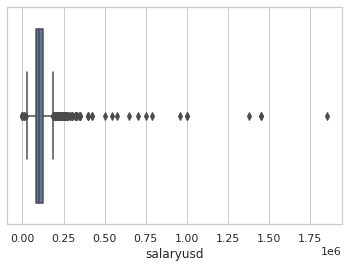

In [177]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=df1["salaryusd"])

count      5593.000000
mean     106365.748614
std       34256.961212
min       11100.000000
25%       85000.000000
50%      103000.000000
75%      125000.000000
max      350000.000000
Name: salaryusd, dtype: float64

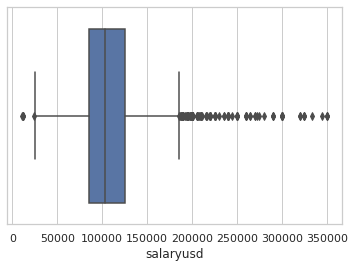

In [178]:
df1 = df1[df1['salaryusd'] > 10000]
df1 = df1[df1['salaryusd'] < 360000]
ax = sns.boxplot(x=df1["salaryusd"])
df1['salaryusd'].describe()



In [179]:
save_to_database('../Data/02_intermediate/american_dream_v2.db','salary_survey', df1, True)